# Computing features to train a MLP
This notebook will guide you through the use of the `keras` package to train a multilayer perceptron for handwritten digits classification. You are going to computing the histogram of gradients from the images in the `mnist` dataset (LeCun et al. 1998)

## Loading the packages

In [1]:
# %pip install tensorflow --upgrade
# %pip install keras --upgrade
# %pip install scikit-image
import numpy as np
from matplotlib import pyplot as pl

from skimage.feature import hog
from skimage import data, color, exposure

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from keras.utils import to_categorical

%matplotlib inline

Load the `mnist` dataset and normalize in the range [0, 1]

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, height, width, 1).astype('float32')
X_test = X_test.reshape(n_test, height, width, 1).astype('float32')

X_train /= 255.0
X_test /= 255.0

n_classes = 10

print(n_train, 'train samples')
print(n_test, 'test samples')

# convert class vectors to binary class matrices
Y_train = to_categorical(y_train, n_classes)
Y_test = to_categorical(y_test, n_classes)

60000 train samples
10000 test samples


### An example of how to compute the histogram of gradients
Let's compute the HOG for one image in the test dataset

In [111]:
n_orientations = 8
pix_p_cell = 2
hog_size = int(height * width * n_orientations / (pix_p_cell * pix_p_cell))

In [104]:
fd, hog_image = hog(X_test[0,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=True)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

Show the image and the corresponding gradients

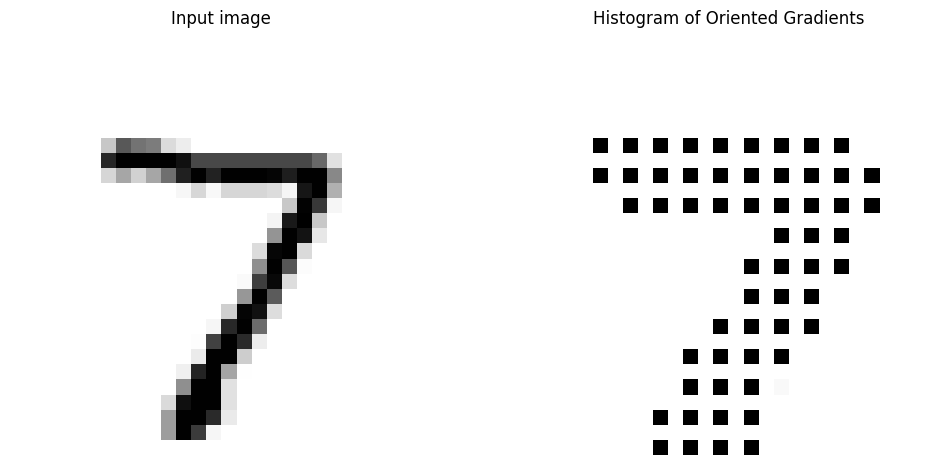

In [105]:
fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(X_test[0,:,:,0], cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax1.set_title('Input image')
ax1.set_adjustable('box')

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box')

Compute the HOGs for the train and test datasets


In [106]:
X_train_hog = np.zeros((X_train.shape[0], hog_size))
X_test_hog = np.zeros((X_test.shape[0], hog_size))

for i in np.arange(X_train_hog.shape[0]):
    X_train_hog[i,:] = hog(X_train[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_train done')

for i in np.arange(X_test_hog.shape[0]):
    X_test_hog[i,:] = hog(X_test[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_test done')

X_train done
X_test done


Create the MLP

In [107]:
model = Sequential()
model.add(Dense(2, input_shape=(hog_size,), activation='relu'))
model.add(Dense(8, input_shape=(hog_size,), activation='relu'))

#model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

c:\Users\Jarod\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_37 (Dense)                │ (None, 2)              │         1,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,684 (6.58 KB)

 Trainable params: 1,684 (6.58 KB)

 Non-trainable params: 0 (0.00 B)

Define some constants and train the MLP

In [108]:
batch_size = 128
n_epoch = 80

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

history = model.fit(X_train_hog, Y_train,
                    batch_size=batch_size, epochs=n_epoch,
                    verbose=1, validation_split=0.1)

Epoch 1/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2283 - loss: 1.9821 - val_accuracy: 0.4857 - val_loss: 1.3426
Epoch 2/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4849 - loss: 1.3057 - val_accuracy: 0.5355 - val_loss: 1.0894
Epoch 3/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5634 - loss: 1.1070 - val_accuracy: 0.6397 - val_loss: 0.9825
Epoch 4/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6227 - loss: 1.0164 - val_accuracy: 0.6870 - val_loss: 0.9052
Epoch 5/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6609 - loss: 0.9536 - val_accuracy: 0.7030 - val_loss: 0.8567
Epoch 6/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6811 - loss: 0.9071 - val_accuracy: 0.7222 - val_loss: 0.8131
Epoch 7/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6962 - loss: 0.8722 - val_accuracy: 0.7278 - val_loss: 0.7898
Epoch 8/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7041 - loss: 0.8583 - val_accuracy: 0.

Show the performance of the model

Test score: 0.569071352481842
Test accuracy: 0.8205000162124634


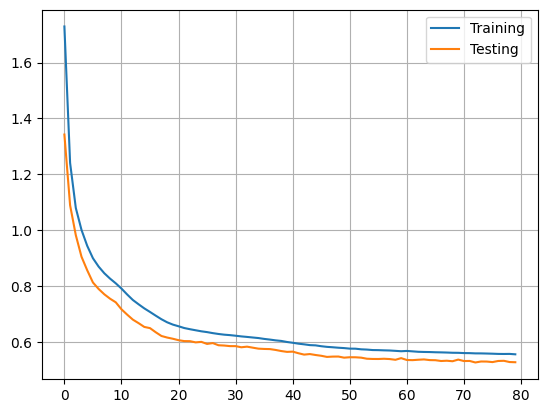

In [109]:
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

score = model.evaluate(X_test_hog, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step


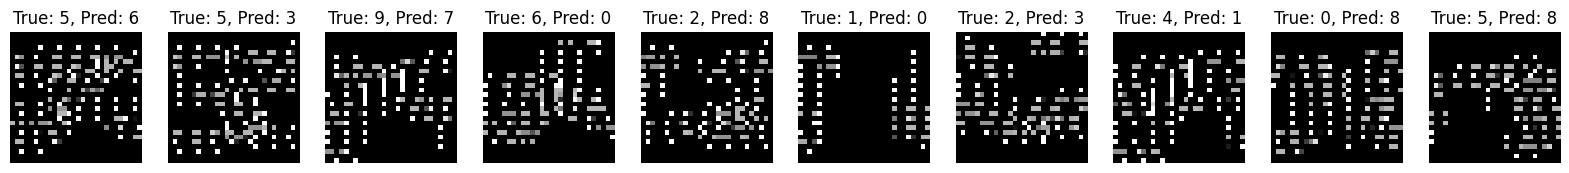

In [112]:
# Function to plot misclassified images
def plot_misclassified_images(X, y_true, y_pred, class_names, max_images=10):
    misclassified_indices = np.where(y_pred != y_true)[0]
    num_misclassified = len(misclassified_indices)
    
    if num_misclassified > 0:
        fig, axes = pl.subplots(1, min(max_images, num_misclassified), figsize=(20, 4))
        for ax, index in zip(axes.flat, misclassified_indices[:max_images]):
            ax.imshow(X[index].reshape(28, 28), cmap='gray', interpolation='none')
            ax.set_title(f"True: {class_names[y_true[index]]}, Pred: {class_names[y_pred[index]]}")
            ax.axis('off')
        pl.show()
    else:
        print("No misclassified images to show.")

# Predicting labels
y_pred = model.predict(X_test_hog)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(Y_test, axis=1)

# Plot misclassified images
plot_misclassified_images(X_test_hog, y_true_classes, y_pred_classes, class_names=[str(i) for i in range(10)])

Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

pred = model.predict(X_test_hog)
pred = np.argmax(pred, axis=-1)
confusion_matrix(y_test, pred)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[ 787,    1,   39,    1,    2,   65,   59,    6,   17,    3],
       [   1, 1051,    1,   13,    6,    5,    2,    5,   46,    5],
       [  63,    9,  648,  173,   18,   58,   10,    6,   47,    0],
       [   7,   14,   96,  672,    2,   65,    2,   77,   70,    5],
       [   2,    8,    0,    0,  756,    5,   48,    6,   33,  124],
       [  39,   12,   28,  148,   40,  274,   66,   76,  185,   24],
       [  56,    2,    2,    1,   33,   26,  824,    0,   14,    0],
       [   1,   25,    1,   21,   10,    1,    1,  787,   12,  169],
       [  20,   38,   19,   81,   44,  166,   16,   75,  493,   22],
       [   5,    8,    4,    7,   79,    9,    5,   79,   25,  788]],
      dtype=int64)